In [1]:

import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gen import generate_data

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad

# Reproductibilité 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


C:\Users\ainar\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Using device: cpu


In [2]:
#Génération de données haute résolution (~10 000 points)
from datetime import datetime
def log(msg): print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

params = dict(
    tau=1e-11,           # s
    fluence=300.0,       # J/m^2
    wavelength=400e-9,   # m
    t_end=60e-12,        # durée totale simulée
    steps_per_tau=1600   # densité très élevée (~10k points)
)

log("Generating high-density data (~10k points)...")
time, Te, Tl, Tw, sigma_abs = generate_data(**params)

import pandas as pd, matplotlib.pyplot as plt, numpy as np
data = pd.DataFrame({"time_s": time, "T_e_K": Te, "T_l_K": Tl, "T_w_K": Tw})

# Infos pratiques
dt = float(time[1]-time[0]) if len(time) > 1 else float('nan')
log(f"points = {len(time):,} | dt = {dt:.3e} s | t_end = {params['t_end']:.3e} s")
log(f"sigma_abs = {sigma_abs:.3e} m^2")
display(data.head())

[09:50:12] Generating high-density data (~10k points)...
[09:50:12] points = 9,600 | dt = 6.250e-15 s | t_end = 6.000e-11 s
[09:50:12] sigma_abs = 7.786e-18 m^2


,time_s,T_e_K,T_l_K,T_w_K
0,0.000000e+00,300.000000,300.000000,300.0
1,6.250000e-15,302.728601,300.000000,300.0
2,1.250000e-14,305.385660,300.000379,300.0
3,1.875000e-14,307.974559,300.001127,300.0
4,2.500000e-14,310.498448,300.002234,300.0


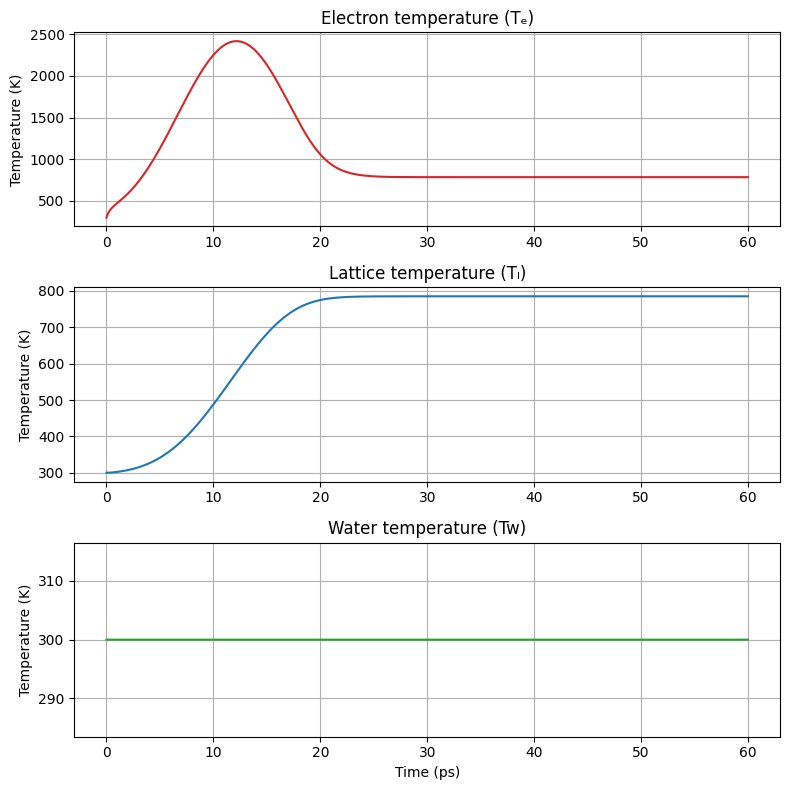

[09:50:12] Dense data plotted (3 separate graphs).


In [3]:
#Plot de contrôle (3 sous-graphiques séparés) 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

# --- Electron temperature ---
plt.subplot(3, 1, 1)
plt.plot(data["time_s"]/1e-12, data["T_e_K"], color="tab:red")
plt.title("Electron temperature (Tₑ)")
plt.ylabel("Temperature (K)")
plt.grid(True)

# --- Lattice temperature ---
plt.subplot(3, 1, 2)
plt.plot(data["time_s"]/1e-12, data["T_l_K"], color="tab:blue")
plt.title("Lattice temperature (Tₗ)")
plt.ylabel("Temperature (K)")
plt.grid(True)

# --- Water temperature ---
plt.subplot(3, 1, 3)
plt.plot(data["time_s"]/1e-12, data["T_w_K"], color="tab:green")
plt.title("Water temperature (Tw)")
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.grid(True)

plt.tight_layout()
plt.show()
log("Dense data plotted (3 separate graphs).")


# Tache 1 : Ajustement de courbes

Tâche 1 - Ajustement de courbes (modèle classique)

In [4]:
#Split chronologique (70/15/15)
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

log(f"Split done → train:{len(X_train)} | val:{len(X_val)} | test:{len(X_test)} | total:{N}")


[09:50:12] Split done → train:6720 | val:1440 | test:1440 | total:9600


In [5]:
# Normalisation des données 
from sklearn.preprocessing import StandardScaler
import numpy as np

# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

log(f"t_max = {t_max:.3e} s")
log(f"y mean = {y_scaler.mean_}")
log(f"y scale = {y_scaler.scale_}")


[09:50:12] t_max = 4.199e-11 s
[09:50:12] y mean = [1057.86262516  693.87588789  300.        ]
[09:50:12] y scale = [525.80717037 161.58687313   1.        ]


In [6]:
# === Datasets et DataLoaders ===
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

log(f"DataLoaders ready → train:{len(train_loader)} batches | val:{len(val_loader)} | test:{len(test_loader)}")


[09:50:12] DataLoaders ready → train:105 batches | val:6 | test:6


In [7]:
# Modèle MLP 
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")


[09:50:12] MLP initialisé → 4483 paramètres entraînables sur cpu


In [8]:
# Entraînement 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS, PATIENCE = 400, 30

best_val = np.inf
wait = 0
best_state = None
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    # phase train 
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # phase val 
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    improved = val_loss < best_val - 1e-8
    if improved:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch % 20 == 0 or epoch == 1 or improved:
        log(f"Epoch {epoch:03d} | Train={train_loss:.6f} | Val={val_loss:.6f} | Best={best_val:.6f} | Wait={wait}")
    if wait >= PATIENCE:
        log(f"Early stopping at epoch {epoch}")
        break

model.load_state_dict(best_state)
log("Best model restored.")


[09:50:15] Epoch 001 | Train=0.547947 | Val=0.191459 | Best=0.191459 | Wait=0
[09:50:16] Epoch 002 | Train=0.283678 | Val=0.094700 | Best=0.094700 | Wait=0
[09:50:16] Epoch 004 | Train=0.057907 | Val=0.013378 | Best=0.013378 | Wait=0
[09:50:16] Epoch 005 | Train=0.015229 | Val=0.000938 | Best=0.000938 | Wait=0
[09:50:17] Epoch 006 | Train=0.004950 | Val=0.000701 | Best=0.000701 | Wait=0
[09:50:17] Epoch 007 | Train=0.002403 | Val=0.000217 | Best=0.000217 | Wait=0
[09:50:18] Epoch 010 | Train=0.000879 | Val=0.000124 | Best=0.000124 | Wait=0
[09:50:20] Epoch 018 | Train=0.000365 | Val=0.000101 | Best=0.000101 | Wait=0
[09:50:21] Epoch 020 | Train=0.000286 | Val=0.000277 | Best=0.000101 | Wait=2
[09:50:21] Epoch 021 | Train=0.000248 | Val=0.000070 | Best=0.000070 | Wait=0
[09:50:25] Epoch 036 | Train=0.000062 | Val=0.000069 | Best=0.000069 | Wait=0
[09:50:26] Epoch 039 | Train=0.000035 | Val=0.000057 | Best=0.000057 | Wait=0
[09:50:27] Epoch 040 | Train=0.000084 | Val=0.000144 | Best=0.00

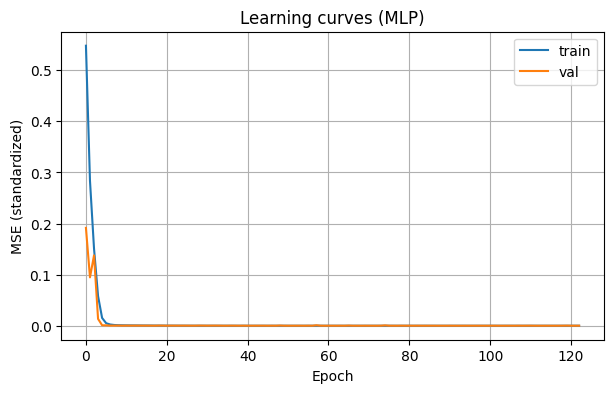

[09:50:50] Courbes d’apprentissage affichées.


In [9]:
plt.figure(figsize=(7,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE (standardized)")
plt.title("Learning curves (MLP)")
plt.legend(); plt.grid(True)
plt.show()
log("Courbes d’apprentissage affichées.")


In [10]:
model.eval()
preds_s, trues_s = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds_s.append(model(xb).cpu().numpy())
        trues_s.append(yb.numpy())

preds_s = np.vstack(preds_s)
trues_s = np.vstack(trues_s)

# inverse scaling
preds = y_scaler.inverse_transform(preds_s)
trues = y_scaler.inverse_transform(trues_s)

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
for i, name in enumerate(["T_e_K","T_l_K","T_w_K"]):
    mae = mean_absolute_error(trues[:,i], preds[:,i])
    r   = rmse(trues[:,i], preds[:,i])
    log(f"{name:6s} | MAE={mae:.4f} K | RMSE={r:.4f} K")


[09:50:50] T_e_K  | MAE=13.6356 K | RMSE=14.4097 K
[09:50:50] T_l_K  | MAE=2.8222 K | RMSE=3.0060 K
[09:50:50] T_w_K  | MAE=0.0064 K | RMSE=0.0066 K


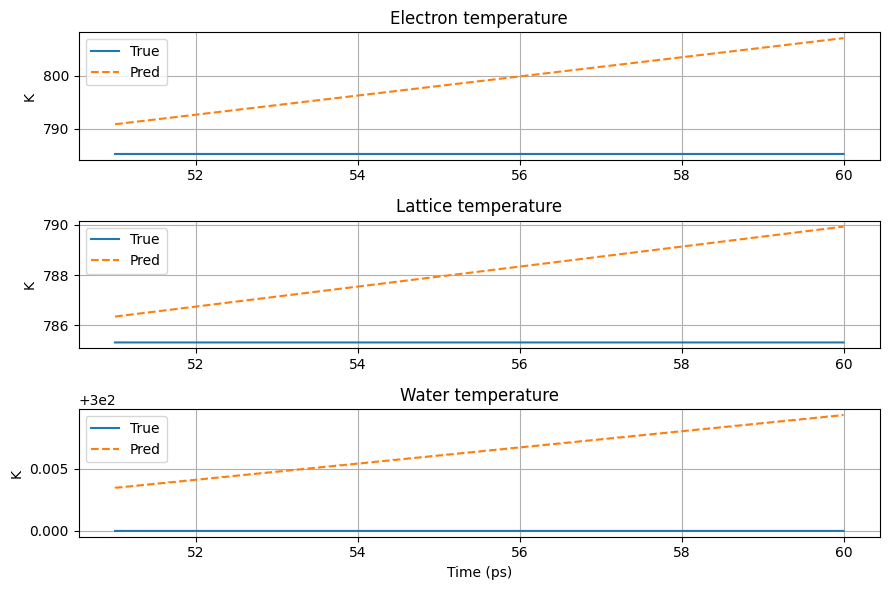

,time_ps,true_K,pred_K,abs_err_K
0,53,785.316,794.473,9.158
1,54,785.316,796.266,10.951
2,55,785.316,798.060,12.744
3,56,785.316,799.854,14.538
4,57,785.316,801.647,16.331
5,58,785.316,803.440,18.125
6,59,785.316,805.234,19.918
7,60,785.316,807.016,21.701


,time_ps,true_K,pred_K,abs_err_K
0,53,785.316,787.143,1.828
1,54,785.316,787.542,2.226
2,55,785.316,787.940,2.624
3,56,785.316,788.338,3.023
4,57,785.316,788.737,3.421
5,58,785.316,789.135,3.819
6,59,785.316,789.533,4.217
7,60,785.316,789.929,4.613


,time_ps,true_K,pred_K,abs_err_K
0,53,300.000,300.005,0.005
1,54,300.000,300.005,0.005
2,55,300.000,300.006,0.006
3,56,300.000,300.007,0.007
4,57,300.000,300.007,0.007
5,58,300.000,300.008,0.008
6,59,300.000,300.009,0.009
7,60,300.000,300.009,0.009


In [11]:
# Comparaison True/Pred + tableaux 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Prépare le DataFrame test
test_plot = pd.DataFrame({
    "time_s": X_test.squeeze(),
    "T_e_true": trues[:,0], "T_l_true": trues[:,1], "T_w_true": trues[:,2],
    "T_e_pred": preds[:,0], "T_l_pred": preds[:,1], "T_w_pred": preds[:,2],
})

# Plots True vs Pred (3 sous-graphiques)
plt.figure(figsize=(9,6))
for i,(true_col,pred_col,title) in enumerate([
    ("T_e_true","T_e_pred","Electron temperature"),
    ("T_l_true","T_l_pred","Lattice temperature"),
    ("T_w_true","T_w_pred","Water temperature"),
]):
    plt.subplot(3,1,i+1)
    plt.plot(test_plot["time_s"]/1e-12, test_plot[true_col], label="True")
    plt.plot(test_plot["time_s"]/1e-12, test_plot[pred_col], "--", label="Pred")
    plt.ylabel("K"); plt.legend(); plt.grid(True); plt.title(title)
plt.xlabel("Time (ps)")
plt.tight_layout(); plt.show()

# Tables compactes aux temps 53..60 ps
target_ps = np.arange(53, 61)  # 53,54,...,60
time_ps = test_plot["time_s"].values / 1e-12

def nearest_indices(time_ps_array, targets_ps):
    return [int(np.argmin(np.abs(time_ps_array - ps))) for ps in targets_ps]

idxs = nearest_indices(time_ps, target_ps)

def make_table(true_col, pred_col, caption):
    sub = test_plot.iloc[idxs][["time_s", true_col, pred_col]].copy()
    sub["time_ps"] = sub["time_s"] / 1e-12
    sub["abs_err_K"] = (sub[pred_col] - sub[true_col]).abs()
    sub = sub[["time_ps", true_col, pred_col, "abs_err_K"]].sort_values("time_ps").reset_index(drop=True)
    sub = sub.rename(columns={true_col:"true_K", pred_col:"pred_K"})
    styled = sub.style.format({"time_ps":"{:.0f}", "true_K":"{:.3f}", "pred_K":"{:.3f}", "abs_err_K":"{:.3f}"}).set_caption(caption)
    display(styled)

make_table("T_e_true","T_e_pred","T_e — points 53..60 ps")
make_table("T_l_true","T_l_pred","T_l — points 53..60 ps")
make_table("T_w_true","T_w_pred","T_w — points 53..60 ps")


# tache 2 : 

pour qui travaille sur la tache 2 , mettez ton travail en des cellules dans ce MarKdown pour eviter les conflits

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import grad 
import pandas as pd


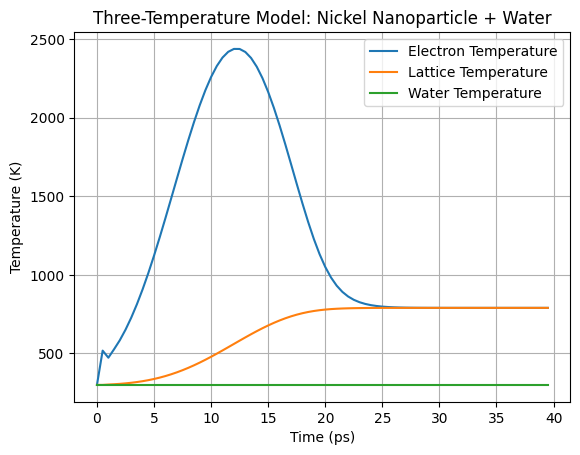

In [13]:
# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100     # J/(m^3*K^2)  -> Ce(Te) = C_e_coeff * Te
C_i = 4.5e6         # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6       # Heat capacity of water, J/(m^3*K)
gamma = 1e17        # Electron-phonon coupling constant, W/(m^3*K)
h = 1e5             # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300           # Initial temperature, K
radius = 5e-9
area = np.pi * (radius**2)
volume = (4/3) * np.pi * (radius**3)
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume

def generate_data(
    fluence=300,          # J/m^2  (30 mJ/cm^2) , laser fluence
    tau=1e-11,            # s  ,pulse duration (100 fs)
    wavelength=400e-9,    # m  , laser wavelength
    n=2.3,                # refractive index (Nickel, approx)
    k=3.5,                # extinction coefficient
    t_end=40e-12,         # s, simulate up to 40 ps
    steps_per_tau=20      # time resolution: dt = tau / steps_per_tau
):
    # optical props
    epsilon = (n + 1j * k)**2
    epsilon_m = 1.77  # water dielectric
    sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

    # time axis
    time_step = tau / steps_per_tau
    time = np.arange(0, t_end, time_step)

    # laser pulse (Gaussian centered around t = tau)
    def gaussian_pulse(t):
        return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2)

    intensity = gaussian_pulse(time)
    Q = (sigma_abs * intensity) / volume  # W/m^3

    # init temps
    Te = np.zeros(len(time)); Ti = np.zeros(len(time)); Tw = np.zeros(len(time))
    Te[0] = T_m; Ti[0] = T_m; Tw[0] = T_m

    # explicit update
    for i in range(0, len(time) - 1):
        C_e = C_e_coeff * Te[i]
        dt = time_step

        Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
        Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
        Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

        # clamp to non-negative
        Te[i + 1] = max(Te[i + 1], 0.0)
        Ti[i + 1] = max(Ti[i + 1], 0.0)
        Tw[i + 1] = max(Tw[i + 1], 0.0)
    
    return time, Te, Ti, Tw, sigma_abs

time, Te, Ti, Tw, sigma_abs = generate_data(fluence=300,tau=1e-11,wavelength=400e-9)
# Plotting the results
plt.plot(time / (1e-12), Te, label="Electron Temperature")
plt.plot(time / (1e-12), Ti, label="Lattice Temperature")
plt.plot(time / (1e-12), Tw, label="Water Temperature")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model: Nickel Nanoparticle + Water")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
data = pd.DataFrame({
    "time_s": time,
    "T_e_K": Te,
    "T_l_K": Ti,
    "T_w_K": Tw,
})

In [15]:
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

Split data

In [16]:
X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)   # total number of samples
n_train = int(0.60 * N)
n_val   = int(0.20 * N)
n_test  = N - n_train - n_val
log(f"Total samples: {N} (train: {n_train}, val: {n_val}, test: {n_test})")
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val     = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
X_test, y_test   = X[n_train + n_val:], y[n_train + n_val:]

[09:50:51] Total samples: 80 (train: 48, val: 16, test: 16)


Normalisation des données

In [17]:
from sklearn.preprocessing import StandardScaler
# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

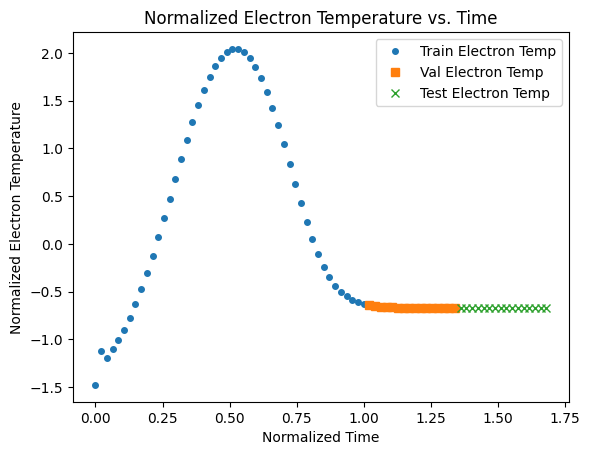

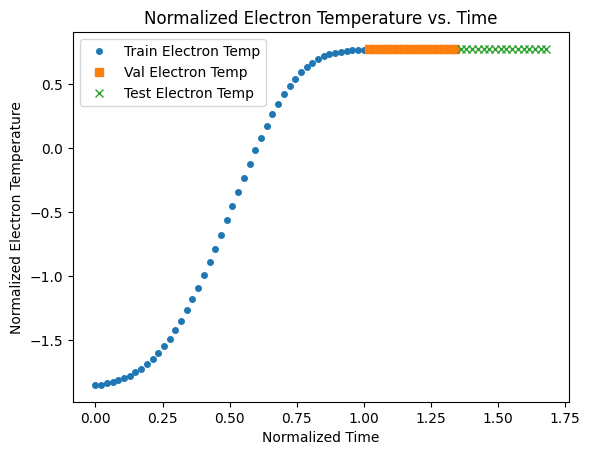

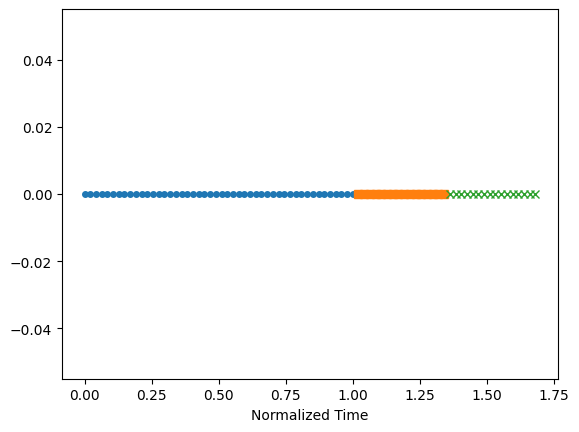

In [18]:
# representation des données normalisées
plt.figure(1)
plt.plot(X_train_s, y_train_s[:, 0], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 0], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 0], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Electron Temperature')
plt.legend()
plt.title('Normalized Electron Temperature vs. Time')
plt.figure(2)
plt.plot(X_train_s, y_train_s[:, 1], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 1], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 1], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Electron Temperature')
plt.legend()
plt.title('Normalized Electron Temperature vs. Time')
plt.figure(3)
plt.plot(X_train_s, y_train_s[:, 2], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 2], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 2], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')   
plt.show()

In [19]:
# === Datasets et DataLoaders ===
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, shuffle=True)  # schuffle est important pour le training parce que les données sont ordonnées dans le temps
val_loader   = DataLoader(val_ds,  shuffle=False)
test_loader  = DataLoader(test_ds, shuffle=False)

In [20]:
import random
# Reproductibilité - Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Usingggg device: {device}")

 Usingggg device: cpu


In [21]:
# === Modèle MLP ===
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")

[09:50:52] MLP initialisé → 4483 paramètres entraînables sur cpu


In [22]:
def grad(outputs, inputs):
    """Partial derivative d(outputs)/d(inputs)."""
    return torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )[0]

def physics_loss(model, device, 
                 R_e=1.0, R_l=1.0, R_w=1.0, Tenv=300.0,
                 n_collocation=200):
    
    # Collocation points sur le bon device
    ts = torch.linspace(0, 1000, steps=n_collocation, device=device).view(-1,1)
    ts.requires_grad_(True)

    temps = model(ts)

    T_e = temps[:, 0:1]
    T_l = temps[:, 1:2]
    T_w = temps[:, 2:3]

    dT_e = grad(T_e, ts)
    dT_l = grad(T_l, ts)
    dT_w = grad(T_w, ts)

    ode_e = dT_e - R_e*(Tenv - T_e)
    ode_l = dT_l - R_l*(Tenv - T_l)
    ode_w = dT_w - R_w*(Tenv - T_w)

    # utiliser mean pour normaliser
    loss_phys = (ode_e.pow(2).mean() +
                 ode_l.pow(2).mean() +
                 ode_w.pow(2).mean())

    return loss_phys


Entrainement sans PINN

In [23]:
# === Entraînement ===
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#lambda_phys = 0.1  # pondération de la loss physique
n_epochs = 200
history = {"train": [], "val": []}
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss_data = criterion(outputs, y_batch)
        #loss_phys = physics_loss(model)
        loss = loss_data #+ lambda_phys* loss_phys  # pondération de la loss physique

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # val_loss += loss.item() * X_batch.size(0)
            val_loss += loss.item() * len(X_batch)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

[09:50:52] Epoch [1/200] - Train Loss: 0.729722, Val Loss: 0.595459
[09:50:52] Epoch [2/200] - Train Loss: 0.595767, Val Loss: 0.453346
[09:50:52] Epoch [3/200] - Train Loss: 0.475070, Val Loss: 0.400254
[09:50:52] Epoch [4/200] - Train Loss: 0.393948, Val Loss: 0.388097
[09:50:52] Epoch [5/200] - Train Loss: 0.348271, Val Loss: 0.498907
[09:50:52] Epoch [6/200] - Train Loss: 0.315650, Val Loss: 0.428272
[09:50:53] Epoch [7/200] - Train Loss: 0.290708, Val Loss: 0.320887
[09:50:53] Epoch [8/200] - Train Loss: 0.261179, Val Loss: 0.270648
[09:50:53] Epoch [9/200] - Train Loss: 0.236422, Val Loss: 0.202887
[09:50:53] Epoch [10/200] - Train Loss: 0.198415, Val Loss: 0.205909
[09:50:53] Epoch [11/200] - Train Loss: 0.170335, Val Loss: 0.188160
[09:50:53] Epoch [12/200] - Train Loss: 0.140253, Val Loss: 0.181983
[09:50:53] Epoch [13/200] - Train Loss: 0.113019, Val Loss: 0.157749
[09:50:53] Epoch [14/200] - Train Loss: 0.083325, Val Loss: 0.213041
[09:50:53] Epoch [15/200] - Train Loss: 0.0

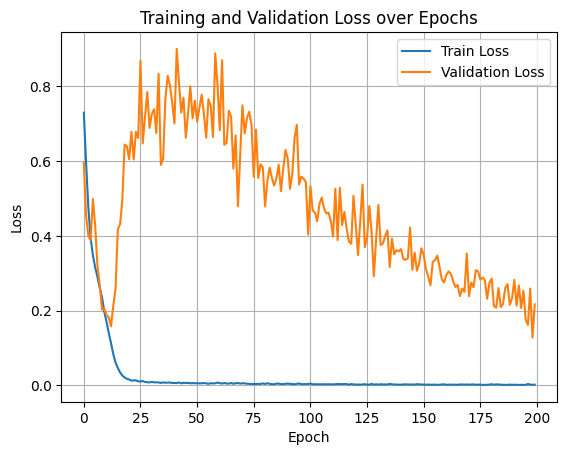

In [24]:
# Representation des courbes d'apprentissage
plt.plot(history["train"], label="Train Loss")
plt.plot(history["val"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Entrainement avec PINN

In [25]:
# === Entraînement ===
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer =torch.optim.
lambda_phys = 1e-3  # pondération de la loss physique
n_epochs = 200
history = {"train": [], "val": []}
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss_data = criterion(outputs, y_batch)
        loss_phys = physics_loss(model,device)
        loss = loss_data + lambda_phys* loss_phys  # pondération de la loss physique

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # val_loss += loss.item() * X_batch.size(0)
            val_loss += loss.item() * len(X_batch)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

[09:51:10] Epoch [1/200] - Train Loss: 1357.466004, Val Loss: 0.937294
[09:51:11] Epoch [2/200] - Train Loss: 73.643902, Val Loss: 1.003431
[09:51:11] Epoch [3/200] - Train Loss: 67.823127, Val Loss: 0.723175
[09:51:11] Epoch [4/200] - Train Loss: 67.713641, Val Loss: 0.516438
[09:51:12] Epoch [5/200] - Train Loss: 67.652180, Val Loss: 0.388893
[09:51:12] Epoch [6/200] - Train Loss: 67.598242, Val Loss: 0.345220
[09:51:12] Epoch [7/200] - Train Loss: 67.544303, Val Loss: 0.241721
[09:51:13] Epoch [8/200] - Train Loss: 67.494045, Val Loss: 0.205230
[09:51:13] Epoch [9/200] - Train Loss: 67.441556, Val Loss: 0.157194
[09:51:13] Epoch [10/200] - Train Loss: 67.390317, Val Loss: 0.126819
[09:51:13] Epoch [11/200] - Train Loss: 67.338413, Val Loss: 0.147312
[09:51:14] Epoch [12/200] - Train Loss: 67.281288, Val Loss: 0.122564
[09:51:14] Epoch [13/200] - Train Loss: 67.226742, Val Loss: 0.094936
[09:51:14] Epoch [14/200] - Train Loss: 67.172063, Val Loss: 0.132186
[09:51:15] Epoch [15/200] -

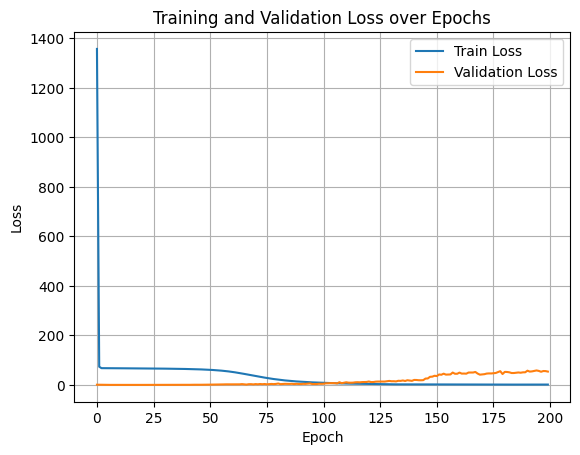

In [26]:
# Representation des courbes d'apprentissage
plt.plot(history["train"], label="Train Loss")
plt.plot(history["val"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# tache 3 :

meme chose pour la tache 3 